<a href="https://colab.research.google.com/github/urvashii-b/Challenges2024/blob/master/Pipsql.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nltk rouge


In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.1 MB/s eta 0:00:00


In [ ]:
!pip install transformers

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
model = AutoModelForCausalLM.from_pretrained("PipableAI/pip-sql-1.3b").to("cuda") #if GPU present
tokenizer = AutoTokenizer.from_pretrained("PipableAI/pip-sql-1.3b")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/730 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/18.0k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/400M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.24k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/442 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
text = '''<schema>
CREATE TABLE Employees (
    EmployeeID INT PRIMARY KEY,
    FirstName VARCHAR(50),
    LastName VARCHAR(50),
    Email VARCHAR(100),
    Department VARCHAR(50),
    Position VARCHAR(50),
    Salary DECIMAL(10, 2),
    HireDate DATE
);</schema>
<question>
Write an SQL query to retrieve the total number of employees in each department along with the average salary for each department.
Display the results sorted in descending order of the average salary.</question><sql>'''
inputs = tokenizer(text, return_tensors="pt").to("cuda") # if gpu present
outputs = model.generate(**inputs, max_new_tokens=200)
print(tokenizer.decode(outputs[0], skip_special_tokens=True).split('<sql>')[1].split('</sql>')[0])

Setting `pad_token_id` to `eos_token_id`:32021 for open-end generation.


SELECT Department, COUNT(*) , AVG(Salary) FROM Employees GROUP BY Department ORDER BY AVG(Salary) DESC


In [ ]:
text = '''<schema>
CREATE TABLE Employees (
    EmployeeID INT PRIMARY KEY,
    FirstName VARCHAR(50),
    LastName VARCHAR(50),
    Email VARCHAR(100),
    Department VARCHAR(50), #Name of the department
    Position VARCHAR(50),
    Salary DECIMAL(10, 2),
    HireDate DATE
);</schema>
<question>
Write a query to get  department name and number of employees in them from the table above</question><sql>'''
inputs = tokenizer(text, return_tensors="pt").to("cuda") # if gpu present
outputs = model.generate(**inputs, max_new_tokens=200)
print(tokenizer.decode(outputs[0], skip_special_tokens=True).split('<sql>')[1].split('</sql>')[0])

Setting `pad_token_id` to `eos_token_id`:32021 for open-end generation.


SELECT Department ,  COUNT(*) FROM Employees GROUP BY Department


In [ ]:
# Given schema and question
table_schema = "CREATE TABLE head (age INTEGER)"
question = "How many heads of the departments are older than 56 ?"

# Construct input prompt
system_msg = f" Generate a correct SQL query from the following database schema. \n {table_schema} "
prompt = f"<s>[INST] {system_msg} \n{question} [/INST]"

def generate_sql(prompt):
  inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
  outputs = model.generate(**inputs, max_new_tokens=200)
  generated_sql = tokenizer.decode(outputs[0], skip_special_tokens=True)

  # Extract SQL query from generated output
  if '<sql>' in generated_sql and '</sql>' in generated_sql:
      extracted_sql = generated_sql.split('<sql>')[1].split('</sql>')[0]
      return extracted_sql

  else:
      print("Unable to extract SQL query from the generated output.")
generated_sql=generate_sql(prompt)
print(f"Generated SQL Query :{generated_sql}")

Setting `pad_token_id` to `eos_token_id`:32021 for open-end generation.


Generated SQL Query :SELECT count(*) FROM head WHERE age  >  56


In [ ]:
from datasets import load_dataset
dataset = load_dataset("b-mc2/sql-create-context")



Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['context', 'question', 'answer'],
        num_rows: 78577
    })
})

In [ ]:
sample = dataset['train'][0]
context = sample['context']
question = sample['question']
answer = sample['answer']

# Construct input prompt
input_prompt = f"<schema>\n{context}\n<question>\n{question}</question><sql>"
generated_sql=generate_sql(input_prompt)
print(f"Generated SQL Query :{generated_sql}")
print(f"Actual SQL query: {answer}")


Setting `pad_token_id` to `eos_token_id`:32021 for open-end generation.


Generated SQL Query :SELECT count(*) FROM head WHERE age  >  56
Actual SQL query: SELECT COUNT(*) FROM head WHERE age > 56


In [ ]:
dataset.keys()

dict_keys(['train'])

In [ ]:
import pandas as pd

data = []

for i, row in enumerate(dataset['train']):
    if i >= 200:  # Limit to 500 rows (optional)
        break

    context = row['context']
    question = row['question']
    answer = row['answer']

    input_prompt = f"<schema>\n{context}\n<question>\n{question}</question><sql>"
    generated_sql = generate_sql(input_prompt)

    data.append({
        'Context': context,
        'Question': question,
        'Actual Answer': answer,
        'Generated SQL': generated_sql
    })

# Create a DataFrame
df = pd.DataFrame(data)

# Print the DataFrame
print(df)


Setting `pad_token_id` to `eos_token_id`:32021 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32021 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32021 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32021 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32021 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32021 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32021 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32021 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32021 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32021 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32021 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32021 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32021 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32021 for open-end gene

                                               Context  \
0                      CREATE TABLE head (age INTEGER)   
1    CREATE TABLE head (name VARCHAR, born_state VA...   
2    CREATE TABLE department (creation VARCHAR, nam...   
3    CREATE TABLE department (budget_in_billions IN...   
4    CREATE TABLE department (num_employees INTEGER...   
..                                                 ...   
195  CREATE TABLE catalog_contents (catalog_entry_n...   
196  CREATE TABLE Catalog_Contents_Additional_Attri...   
197  CREATE TABLE catalog_contents (catalog_entry_n...   
198  CREATE TABLE Catalog_Contents_Additional_Attri...   
199  CREATE TABLE Catalog_Contents (catalog_entry_n...   

                                              Question  \
0    How many heads of the departments are older th...   
1    List the name, born state and age of the heads...   
2    List the creation year, name and budget of eac...   
3    What are the maximum and minimum budget of the...   
4    What is 

In [ ]:
df.to_csv("SQLSyntheticModelpipsql.csv",index=False)

In [ ]:
df

,Context,Question,Actual Answer,Generated SQL
0,CREATE TABLE head (age INTEGER),How many heads of the departments are older th...,SELECT COUNT(*) FROM head WHERE age > 56,SELECT count(*) FROM head WHERE age > 56
1,"CREATE TABLE head (name VARCHAR, born_state VA...","List the name, born state and age of the heads...","SELECT name, born_state, age FROM head ORDER B...","SELECT name , born_state , age FROM head ORD..."
2,"CREATE TABLE department (creation VARCHAR, nam...","List the creation year, name and budget of eac...","SELECT creation, name, budget_in_billions FROM...","SELECT creation , name , budget_in_billions ..."
3,CREATE TABLE department (budget_in_billions IN...,What are the maximum and minimum budget of the...,"SELECT MAX(budget_in_billions), MIN(budget_in_...","SELECT max(budget_in_billions) , min(budget_i..."
4,CREATE TABLE department (num_employees INTEGER...,What is the average number of employees of the...,SELECT AVG(num_employees) FROM department WHER...,SELECT avg(num_employees) FROM department WHER...
...,...,...,...,...
195,CREATE TABLE catalog_contents (catalog_entry_n...,Find the names of all the products whose stock...,SELECT catalog_entry_name FROM catalog_content...,SELECT catalog_entry_name FROM catalog_content...
196,CREATE TABLE Catalog_Contents_Additional_Attri...,Find the names of catalog entries with level n...,SELECT t1.catalog_entry_name FROM Catalog_Cont...,SELECT catalog_entry_name FROM Catalog_Content...
197,CREATE TABLE catalog_contents (catalog_entry_n...,Find the names of the products with length sma...,SELECT catalog_entry_name FROM catalog_content...,SELECT catalog_entry_name FROM catalog_content...
198,CREATE TABLE Catalog_Contents_Additional_Attri...,Find the name and attribute ID of the attribut...,"SELECT t1.attribute_name, t1.attribute_id FROM...","SELECT attribute_name , attribute_id FROM att..."


<ipython-input-15-34344f637830>:22: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


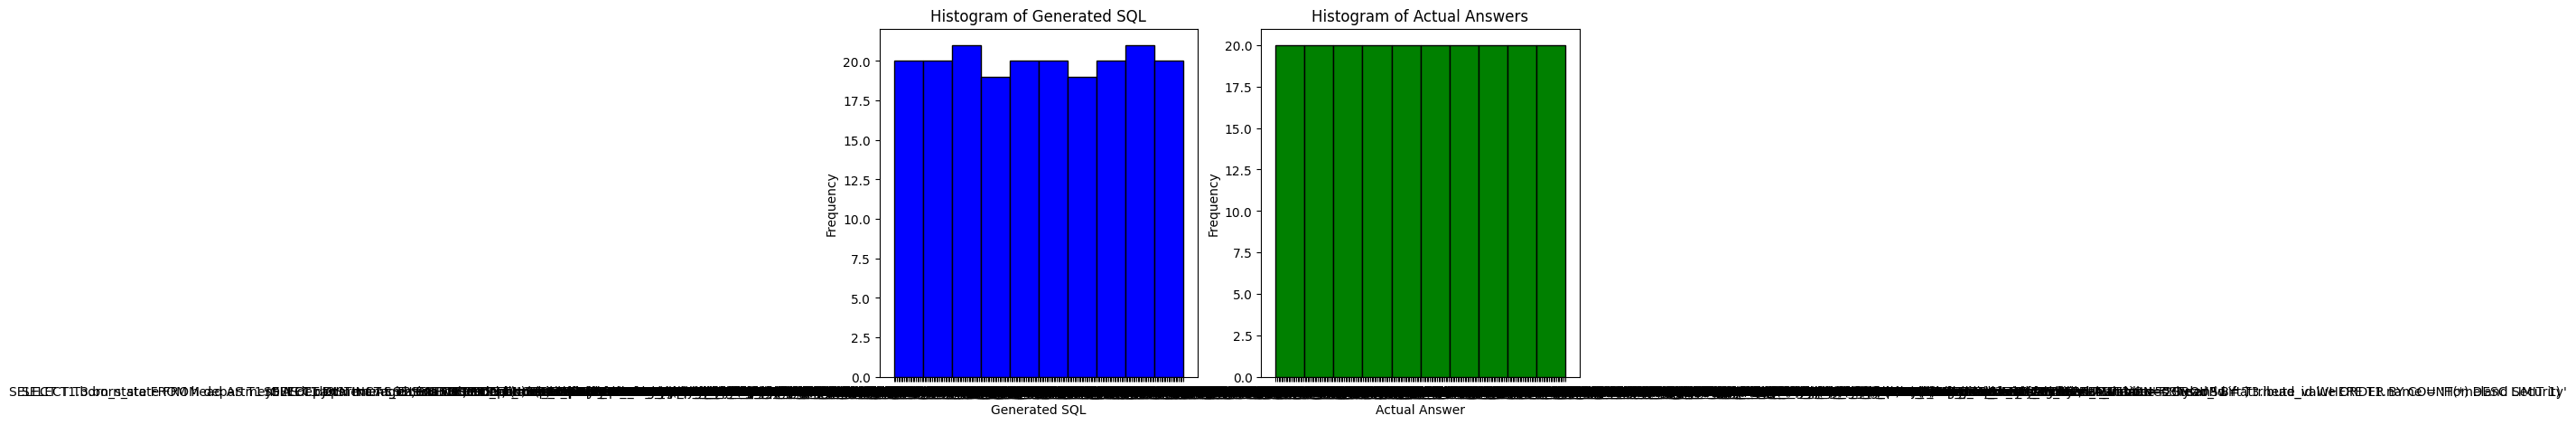

In [ ]:
import matplotlib.pyplot as plt

# Example data for histograms (replace with your data)
generated_sql = df['Generated SQL']
actual_answer = df['Actual Answer']

# Create histograms
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(generated_sql, bins=10, color='blue', edgecolor='black')
plt.xlabel('Generated SQL')
plt.ylabel('Frequency')
plt.title('Histogram of Generated SQL')

plt.subplot(1, 2, 2)
plt.hist(actual_answer, bins=10, color='green', edgecolor='black')
plt.xlabel('Actual Answer')
plt.ylabel('Frequency')
plt.title('Histogram of Actual Answers')

plt.tight_layout()
plt.show()


In [ ]:
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge

# Extract reference texts and candidate texts from your dataset
reference_texts = df['Actual Answer'].tolist()
candidate_texts = df['Generated SQL'].tolist()

# Compute BLEU score
bleu_score = corpus_bleu([[ref.split()] for ref in reference_texts], [cand.split() for cand in candidate_texts])

print(f"BLEU Score: {bleu_score}")

# Initialize Rouge
rouge = Rouge()

# Compute ROUGE score
scores = rouge.get_scores(candidate_texts, reference_texts, avg=True)

print(f"ROUGE Scores: {scores}")



BLEU Score: 0.3951600704998112
ROUGE Scores: {'rouge-1': {'r': 0.7316040646852207, 'p': 0.8161859035572268, 'f': 0.7578753409429078}, 'rouge-2': {'r': 0.5320727424867069, 'p': 0.5780230618491556, 'f': 0.541211226422745}, 'rouge-l': {'r': 0.7271869767336128, 'p': 0.8104237862885304, 'f': 0.7529434505831369}}
